<a href="https://colab.research.google.com/github/JFchien/DataVisualization/blob/main/vesuvius_ink_detection_unet_jofan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

from google.colab import drive
drive.mount('/content/gdrive')

PREFIX = '/content/gdrive/MyDrive/train/1/'

cuda
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# # check if data is loaded
# mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
# label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)
# fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.set_title("mask.png")
# ax1.imshow(mask, cmap='gray')
# ax2.set_title("inklabels.png")
# ax2.imshow(label.cpu(), cmap='gray')
# plt.show()

# vesuvius 3D UNET

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from google.colab import drive
drive.mount('/content/gdrive')

PREFIX = '/content/gdrive/MyDrive/train/1/'

class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER, x-BUFFER:x+BUFFER].view(1, Z_DIM,BUFFER*2, BUFFER*2)
        inklabel = self.label[y-BUFFER:y+BUFFER, x-BUFFER:x+BUFFER].view(1,BUFFER*2, BUFFER*2)
        return subvolume, inklabel

class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.down_conv = nn.Sequential(
          nn.Conv3d(in_c, out_c, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_c),
          nn.Conv3d(out_c, out_c, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_c),
          nn.ReLU()
        )
        self.maxpool=nn.MaxPool3d(kernel_size=2)

    def forward(self,inputs):
        x = self.down_conv(inputs)
        p = self.maxpool(x)
        return x, p

class Up(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_c, out_c, kernel_size=2,  stride=2, padding=0)
        self.up_conv = nn.Sequential(
          nn.Conv3d(in_c, out_c, kernel_size=3, stride=1,padding=1),
          nn.BatchNorm3d(out_c),
          nn.ReLU(),
          nn.Conv3d(out_c, out_c, kernel_size=3,stride=1, padding=1),
          nn.BatchNorm3d(out_c),
          nn.ReLU(),
        )

    def forward(self, x, crop):
        x = self.up(x)
        x = torch.cat([x, crop], dim=1)
        x = self.up_conv(x)
        return x

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = Down(1, 64)
        self.d2 = Down(64, 128)
        self.d3 = Down(128, 256)
        self.d4 = Down(256, 512)
        self.bottleneck = Down(512, 1024)
        self.u4 = Up(1024, 512)
        self.u3 = Up(512, 256)
        self.u2 = Up(256, 128)
        self.u1 = Up(128, 64)
        self.outputs = nn.Conv3d(64, 1, kernel_size=1, padding=0)
    def forward(self, x):
        x1, p1 = self.d1(x)
#         print(f"Size of x1: {x1.size()}")
#         print(f"Size of p1: {p1.size()}")
        x2, p2 = self.d2(p1)
#         print(f"Size of x2: {x2.size()}")
#         print(f"Size of p2: {p2.size()}")
        x3, p3 = self.d3(p2)
#         print(f"Size of x3: {x3.size()}")
#         print(f"Size of p3: {p3.size()}")
        x4, p4 = self.d4(p3)
#         print(f"Size of x4: {x4.size()}")
#         print(f"Size of p4: {p4.size()}")
        b, _ = self.bottleneck(p4)
#         print(f"Size of b: {b.size()}")
        u4 = self.u4(b,x4)
#         print(f"Size of u4: {u4.size()}")
        u3 = self.u3(u4,x3)
        u2 = self.u2(u3,x2)
        u1 = self.u1(u2,x1)
        outputs = self.outputs(u1)
        return outputs

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
DEVICE = torch.device("cpu")
BUFFER=int(512/2)
rect = (1100, 3500, BUFFER*3, BUFFER*3)
LEARNING_RATE = 0.03
BATCH_SIZE = 1

mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)
Z_START = 1
Z_END = 65
Z_DIM=Z_END-Z_START
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_END])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)
print(image_stack.shape)
del images
not_border = np.zeros(mask.shape, dtype=bool)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True
arr_mask = np.array(mask) * not_border
inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
inside_rect[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = True
outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = False
pixels_inside_rect = np.argwhere(inside_rect)
pixels_outside_rect = np.argwhere(outside_rect)

100%|██████████| 64/64 [00:17<00:00,  3.71it/s]


torch.Size([64, 8181, 6330])


In [ ]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
TRAINING_STEPS = 5
model = Unet().to(DEVICE)
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    running_loss = 0.0
    model.train()
    for i, (subvolumes, inklabels) in tqdm(enumerate(dataloader), total=TRAINING_STEPS):
        if i >= TRAINING_STEPS:
            break

        optimizer.zero_grad()
        outputs = model(subvolumes.to(DEVICE))
        loss = loss_fn(outputs, inklabels.to(DEVICE))

        loss.backward()
        optimizer.step()
#         scheduler.step()

        train_loss += loss.item()

    train_loss /= len(dataloader)
    print(f"Train Error: Avg loss: {train_loss:>8f} \n")

    return train_loss

eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for i, (subvolumes, inklabels) in tqdm(enumerate(dataloader), total=TRAINING_STEPS):
            if i >= TRAINING_STEPS:
                break
            outputs = model(subvolumes.to(DEVICE))
            loss = loss_fn(outputs, inklabels.to(DEVICE))
            test_loss += loss.item()
    test_loss /= len(dataloader)
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

    return test_loss

epochs = 2
train_loss_all = []
test_loss_all = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    test_loss = test_loop(eval_loader, model, loss_fn)

    train_loss_all.append(train_loss)
    test_loss_all.append(test_loss)

print("Done!")


Epoch 1
-------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

# vesuvius 2D UNET

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from google.colab import drive
drive.mount('/content/gdrive')

PREFIX = '/content/gdrive/MyDrive/train/1/'

class SubvolumeDataset2D(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[y-BUFFER:y+BUFFER, x-BUFFER:x+BUFFER].view(1,BUFFER*2, BUFFER*2)
        inklabel = self.label[y-BUFFER:y+BUFFER, x-BUFFER:x+BUFFER].view(1,BUFFER*2, BUFFER*2)
        return subvolume, inklabel

class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.down_conv = nn.Sequential(
          nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_c),
          nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_c),
          nn.ReLU()
        )
        self.maxpool=nn.MaxPool2d(kernel_size=2)

    def forward(self,inputs):
        x = self.down_conv(inputs)
        p = self.maxpool(x)
        return x, p

class Up(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2,  stride=2, padding=0)
        self.up_conv = nn.Sequential(
          nn.Conv2d(in_c, out_c, kernel_size=3, stride=1,padding=1),
          nn.BatchNorm2d(out_c),
          nn.ReLU(),
          nn.Conv2d(out_c, out_c, kernel_size=3,stride=1, padding=1),
          nn.BatchNorm2d(out_c),
          nn.ReLU(),
        )

    def forward(self, x, crop):
        x = self.up(x)
        x = torch.cat([x, crop], axis=1)
        x = self.up_conv(x)
        return x

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = Down(1, 64)
        self.d2 = Down(64, 128)
        self.d3 = Down(128, 256)
        self.d4 = Down(256, 512)
        self.bottleneck = Down(512, 1024)
        self.u4 = Up(1024, 512)
        self.u3 = Up(512, 256)
        self.u2 = Up(256, 128)
        self.u1 = Up(128, 64)
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, x):
        x1, p1 = self.d1(x)
#         print(f"Size of x1: {x1.size()}")
#         print(f"Size of p1: {p1.size()}")
        x2, p2 = self.d2(p1)
#         print(f"Size of x2: {x2.size()}")
#         print(f"Size of p2: {p2.size()}")
        x3, p3 = self.d3(p2)
#         print(f"Size of x3: {x3.size()}")
#         print(f"Size of p3: {p3.size()}")
        x4, p4 = self.d4(p3)
#         print(f"Size of x4: {x4.size()}")
#         print(f"Size of p4: {p4.size()}")
        b, _ = self.bottleneck(p4)
#         print(f"Size of b: {b.size()}")
        u4 = self.u4(b,x4)
#         print(f"Size of u4: {u4.size()}")
        u3 = self.u3(u4,x3)
        u2 = self.u2(u3,x2)
        u1 = self.u1(u2,x1)
        outputs = self.outputs(u1)
        return outputs

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
DEVICE = torch.device("cpu")
BUFFER=int(512/2)
rect = (1100, 3500, BUFFER*3, BUFFER*3)
LEARNING_RATE = 0.03
BATCH_SIZE = 4

mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)
Z_START = 10
Z_END = 50
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_END])]
image_stack_flatten = torch.mean(torch.stack([torch.from_numpy(image) for image in images], dim=0), dim=0).to(DEVICE)
print(image_stack_flatten.shape)
del images
not_border = np.zeros(mask.shape, dtype=bool)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True
arr_mask = np.array(mask) * not_border
inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
inside_rect[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = True
outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]] = False
pixels_inside_rect = np.argwhere(inside_rect)
pixels_outside_rect = np.argwhere(outside_rect)

100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


torch.Size([8181, 6330])


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAINING_STEPS = 3000
model = Unet().to(DEVICE)
train_dataset = SubvolumeDataset2D(image_stack_flatten, label, pixels_outside_rect)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    running_loss = 0.0
    model.train()
    for i, (subvolumes, inklabels) in tqdm(enumerate(dataloader), total=TRAINING_STEPS):
        if i >= TRAINING_STEPS:
            break

        optimizer.zero_grad()
        outputs = model(subvolumes.to(DEVICE))
        loss = loss_fn(outputs, inklabels.to(DEVICE))

        loss.backward()
        optimizer.step()
#         scheduler.step()

        train_loss += loss.item()

    train_loss /= len(dataloader)
    print(f"Train Error: Avg loss: {train_loss:>8f} \n")

    return train_loss

eval_dataset = SubvolumeDataset2D(image_stack_flatten, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for i, (subvolumes, inklabels) in tqdm(enumerate(dataloader), total=TRAINING_STEPS):
            if i >= TRAINING_STEPS:
                break
            outputs = model(subvolumes.to(DEVICE))
            loss = loss_fn(outputs, inklabels.to(DEVICE))
            test_loss += loss.item()
    test_loss /= len(dataloader)
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

    return test_loss

epochs = 30
train_loss_all = []
test_loss_all = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    test_loss = test_loop(eval_loader, model, loss_fn)

    train_loss_all.append(train_loss)
    test_loss_all.append(test_loss)

print("Done!")


Epoch 1
-------------------------------


100%|██████████| 3000/3000 [05:30<00:00,  9.07it/s]


Train Error: Avg loss: 0.000063 



100%|██████████| 3000/3000 [01:42<00:00, 29.19it/s]


Test Error: Avg loss: 0.002647 

Epoch 2
-------------------------------


100%|██████████| 3000/3000 [05:28<00:00,  9.13it/s]


Train Error: Avg loss: 0.000057 



100%|██████████| 3000/3000 [01:42<00:00, 29.22it/s]


Test Error: Avg loss: 0.002502 

Epoch 3
-------------------------------


100%|██████████| 3000/3000 [05:28<00:00,  9.14it/s]


Train Error: Avg loss: 0.000028 



100%|██████████| 3000/3000 [01:42<00:00, 29.18it/s]


Test Error: Avg loss: 0.001641 

Epoch 4
-------------------------------


100%|██████████| 3000/3000 [05:28<00:00,  9.13it/s]


Train Error: Avg loss: 0.000011 



100%|██████████| 3000/3000 [01:42<00:00, 29.16it/s]


Test Error: Avg loss: 0.000629 

Epoch 5
-------------------------------


100%|██████████| 3000/3000 [05:28<00:00,  9.12it/s]


Train Error: Avg loss: 0.000007 



100%|██████████| 3000/3000 [01:42<00:00, 29.15it/s]


Test Error: Avg loss: 0.000518 

Epoch 6
-------------------------------


 24%|██▍       | 722/3000 [01:20<04:14,  8.94it/s]


KeyboardInterrupt: 

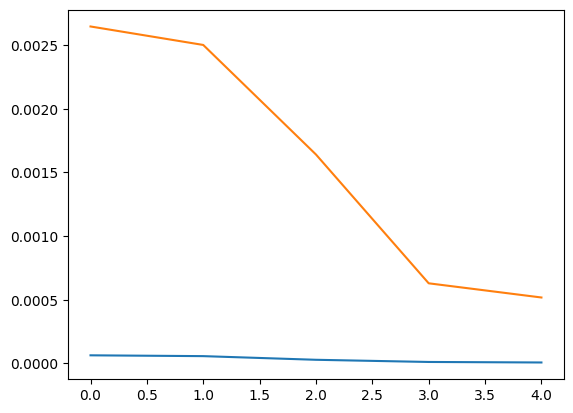

In [ ]:
plt.plot(train_loss_all)
plt.plot(test_loss_all)

# test 2D UNET

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

class SubvolumeDataset2D(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[y-BUFFER:y+BUFFER, x-BUFFER:x+BUFFER].view(1,BUFFER*2, BUFFER*2)
        inklabel = self.label[y-BUFFER:y+BUFFER, x-BUFFER:x+BUFFER].view(1,BUFFER*2, BUFFER*2)
        return subvolume, inklabel

class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.down_conv = nn.Sequential(
          nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_c),
          nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(out_c),
          nn.ReLU()
        )
        self.maxpool=nn.MaxPool2d(kernel_size=2)

    def forward(self,inputs):
        x = self.down_conv(inputs)
        p = self.maxpool(x)
        return x, p

class Up(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2,  stride=2, padding=0)
        self.up_conv = nn.Sequential(
          nn.Conv2d(in_c, out_c, kernel_size=3, stride=1,padding=1),
          nn.BatchNorm2d(out_c),
          nn.ReLU(),
          nn.Conv2d(out_c, out_c, kernel_size=3,stride=1, padding=1),
          nn.BatchNorm2d(out_c),
          nn.ReLU(),
        )

    def forward(self, x, crop):
        x = self.up(x)
        x = torch.cat([x, crop], axis=1)
        x = self.up_conv(x)
        return x

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = Down(1, 64)
        self.d2 = Down(64, 128)
        self.d3 = Down(128, 256)
        self.d4 = Down(256, 512)
        self.bottleneck = Down(512, 1024)
        self.u4 = Up(1024, 512)
        self.u3 = Up(512, 256)
        self.u2 = Up(256, 128)
        self.u1 = Up(128, 64)
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, x):
        x1, p1 = self.d1(x)
#         print(f"Size of x1: {x1.size()}")
#         print(f"Size of p1: {p1.size()}")
        x2, p2 = self.d2(p1)
#         print(f"Size of x2: {x2.size()}")
#         print(f"Size of p2: {p2.size()}")
        x3, p3 = self.d3(p2)
#         print(f"Size of x3: {x3.size()}")
#         print(f"Size of p3: {p3.size()}")
        x4, p4 = self.d4(p3)
#         print(f"Size of x4: {x4.size()}")
#         print(f"Size of p4: {p4.size()}")
        b, _ = self.bottleneck(p4)
#         print(f"Size of b: {b.size()}")
        u4 = self.u4(b,x4)
#         print(f"Size of u4: {u4.size()}")
        u3 = self.u3(u4,x3)
        u2 = self.u2(u3,x2)
        u1 = self.u1(u2,x1)
        outputs = self.outputs(u1)
        return outputs

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet().to(DEVICE)
img=torch.rand(1,1,512,512)
out=model(img.to(DEVICE))
print(img.shape)
print(out.shape)

torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])


# test 3D UNET

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

class Down(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.down_conv = nn.Sequential(
          nn.Conv3d(in_c, out_c, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_c),
          nn.Conv3d(out_c, out_c, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm3d(out_c),
          nn.ReLU()
        )
        self.maxpool=nn.MaxPool3d(kernel_size=2)

    def forward(self,inputs):
        x = self.down_conv(inputs)
        p = self.maxpool(x)
        return x, p

class Up(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_c, out_c, kernel_size=2,  stride=2, padding=0)
        self.up_conv = nn.Sequential(
          nn.Conv3d(in_c, out_c, kernel_size=3, stride=1,padding=1),
          nn.BatchNorm3d(out_c),
          nn.ReLU(),
          nn.Conv3d(out_c, out_c, kernel_size=3,stride=1, padding=1),
          nn.BatchNorm3d(out_c),
          nn.ReLU(),
        )

    def forward(self, x, crop):
        x = self.up(x)
        x = torch.cat([x, crop], dim=1)
        x = self.up_conv(x)
        return x

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = Down(1, 64)
        self.d2 = Down(64, 128)
        self.d3 = Down(128, 256)
        self.d4 = Down(256, 512)
        self.bottleneck = Down(512, 1024)
        self.u4 = Up(1024, 512)
        self.u3 = Up(512, 256)
        self.u2 = Up(256, 128)
        self.u1 = Up(128, 64)
        self.outputs = nn.Conv3d(64, 1, kernel_size=1, padding=0)
    def forward(self, x):
        x1, p1 = self.d1(x)
#         print(f"Size of x1: {x1.size()}")
#         print(f"Size of p1: {p1.size()}")
        x2, p2 = self.d2(p1)
#         print(f"Size of x2: {x2.size()}")
#         print(f"Size of p2: {p2.size()}")
        x3, p3 = self.d3(p2)
#         print(f"Size of x3: {x3.size()}")
#         print(f"Size of p3: {p3.size()}")
        x4, p4 = self.d4(p3)
#         print(f"Size of x4: {x4.size()}")
#         print(f"Size of p4: {p4.size()}")
        b, _ = self.bottleneck(p4)
#         print(f"Size of b: {b.size()}")
        u4 = self.u4(b,x4)
#         print(f"Size of u4: {u4.size()}")
        u3 = self.u3(u4,x3)
        u2 = self.u2(u3,x2)
        u1 = self.u1(u2,x1)
        outputs = self.outputs(u1)
        return outputs
DEVICE = torch.device("cpu")
model = Unet().to(DEVICE)
img=torch.rand(1,1,64,512,512)
out=model(img.to(DEVICE))
print(img.shape)
print(out.shape)

torch.Size([1, 1, 64, 512, 512])
torch.Size([1, 1, 64, 512, 512])
